In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nplab.datafile as df
import scipy.signal as sig
import scipy.constants as const
import peakutils
import numpy as np
import datetime
from peakutils.plot import plot as pplot
from parula import cm_data
from matplotlib.colors import LinearSegmentedColormap 
from matplotlib.collections import LineCollection
import os
import Alexsdatafuncs
import matplotlib.cm as cm
import time

In [2]:
parula_map = LinearSegmentedColormap.from_list('parula', cm_data)
copper_map = LinearSegmentedColormap.from_list('copper', cm_data)

Alex_data = Alexsdatafuncs.data_manipulators()
Alex_plot = Alexsdatafuncs.plotting_funcs()

In [3]:
#    
def big_for(filelist, start_time, finish_time, max_peaks = 7, wavelength_start = 405, wavelength_end = 1000, 
            peakfind_start = 401):
    
    wavelengthvals = filelist[filelist.keys()[0]].attrs['wavelengths']
    data_start = (np.abs(wavelengthvals - wavelength_start)).argmin()
    data_end = (np.abs(wavelengthvals - wavelength_end)).argmin()
    peak_data_start = (np.abs(wavelengthvals - peakfind_start)).argmin()
    data_range = data_end - data_start
    peak_index_store = []
    wavelength_store = []
    name_store = []
    intensity_store_norm = []
    intensity_store = []
    peak_wavelengths_store = []
    peak_intensities_store = []
    min_indexes = []
    min_index_store = []
    min_wavelengths_store = []
    min_intensities_store = []
    timestamp_store = []
    
    #Search for reference spectrum   
    try:
        for i in range(0, len(filelist)):
            try:
                ref = filelist[filelist.keys()[i]].attrs['reference']
                print "Reference spectrum taken from spectrum: " 
                print filelist.keys()[i]
                break
            except KeyError:
                ref = filelist[filelist.keys()[0]]
                pass
    except KeyError:
        print """Coudn't find a stored reference attribute, \n
        find the file containing a reference and paste this into the code"""
        ref = filelist[filelist.keys()[0]]
    
    back = filelist[filelist.keys()[0]].attrs['background']
    x = wavelengthvals

    slash_loc = Alex_data.slashfinder(fname)

    spectrum_indexes = []
    num_peaks_store = []
    intensity_initial_peak_store = []
    initial_peak_wl_store = []
    second_peak_wl_store = []

    peak_width_guess = 50
    exp_number_of_peaks = 2

    no_spectra=-1

    for data_set in filelist.values():

        current_timestamp =  datetime.datetime.strptime(
                data_set.attrs['creation_timestamp'][:19], "%Y-%m-%dT%H:%M:%S")

        no_spectra += 1

        if current_timestamp >= start_time and current_timestamp <= finish_time:

            print "Current spectrum: " + data_set.name[25:]

            spectrum_indexes = np.append(spectrum_indexes, [no_spectra])

            y_raw = np.array(data_set.value)
            y = (y_raw-back)/(ref-back)

            y_red = y[data_start:data_end]
            x_red = x[data_start:data_end]

            #Use Savitsky-Golay noise filter to remove noise if chosen


            y_filtered = sig.savgol_filter(y_red,23,3)
            y_filtered_corr = y_filtered - min(y_filtered)
            y_norm = (y_filtered_corr/max(y_filtered_corr))
            y_red = y_filtered
    #         else:
    #             y_red = y[data_start:data_end] - min(y[data_start:data_end])
    #             y_norm = (y_red/max(y_red))
    #             pass

            #Set peakfinder to only search above set wavelength value with 
            #peak_data_start

            #Automatically search for the correct threshold leading the code to 
            #find the defined number of peaks
            thresh_guess = 0.5
            find_peaks = False
            while find_peaks == False and exp_number_of_peaks != 0:
                peak_indexes = peakutils.indexes(y_norm[peak_data_start:data_end], 
                                                 thres = thresh_guess, 
                                                 min_dist = peak_width_guess*2)
                min_indexes = peakutils.indexes(-1*y_norm[peak_data_start:data_end], 
                                                 thres = thresh_guess, 
                                                 min_dist = peak_width_guess*2)
                if len(peak_indexes) >= exp_number_of_peaks:
                    find_peaks = True
                elif thresh_guess <=0.01:
                    while find_peaks == False:
                        peak_indexes = peakutils.indexes(y_norm[peak_data_start:data_end], 
                                                         thres = thresh_guess, 
                                                         min_dist = peak_width_guess*2)
                        min_indexes = peakutils.indexes(-1*y_norm[peak_data_start:data_end], 
                                                 thres = thresh_guess, 
                                                 min_dist = peak_width_guess*2)
                        if len(peak_indexes) >= exp_number_of_peaks:
                            find_peaks = True
                        elif thresh_guess > 1:
                            print "Didn't find threshold for spectrum" + str(no_spectra)
                            print "Need to change expected number or peaks"
                            thresh_guess = 0.5
                            break
                        else:
                            thresh_guess += 0.01
                    break
                else:
                    thresh_guess -= 0.01

            peak_indexes = peak_indexes + peak_data_start
            min_indexes = min_indexes + peak_data_start
            peak_indexes_orig = peak_indexes
            num_peaks = len(peak_indexes_orig)
            
            #Crop and add points to minima peaks
            if len(min_indexes) > max_peaks:
                while len(min_indexes) > max_peaks:
                    min_indexes = np.delete(min_indexes,[max_peaks])
            elif len(min_indexes) < max_peaks:
                while len(min_indexes) < max_peaks:
                    min_indexes = np.append(min_indexes,[0])
            else:
                pass
            
            #Crop and add 0 to peaks
            if len(peak_indexes) > max_peaks:
                while len(peak_indexes) > max_peaks:
                    peak_indexes = np.delete(peak_indexes,[max_peaks])
            elif len(peak_indexes) < max_peaks:
                while len(peak_indexes) < max_peaks:
                    peak_indexes = np.append(peak_indexes,[0])
            else:
                pass

            peak_wavelengths = []
            min_wavelengths = []
            peak_intensities = []
            min_intensities = []
            for i in range(0,max_peaks):
                if peak_indexes[i] != 0:
                    peak_wavelengths = np.append(peak_wavelengths, 
                                                 [x_red[peak_indexes[i]]])
                else:
                    peak_wavelengths = np.append(peak_wavelengths, [0])
                    
                if peak_indexes[i] != 0:
                    peak_intensities = np.append(peak_intensities, 
                                                 [y_norm[peak_indexes[i]]])
                else:
                    peak_intensities = np.append(peak_intensities, [0])
                    
                if min_indexes[i] != 0:
                    min_wavelengths = np.append(min_wavelengths, 
                                                 [x_red[min_indexes[i]]])
                else:
                    min_wavelengths = np.append(min_wavelengths, [0])
                    
                if min_indexes[i] != 0:
                    min_intensities = np.append(min_intensities, 
                                                 [y_norm[min_indexes[i]]])
                else:
                    min_intensities = np.append(min_intensities, [0])

    
                

            #Gaussian fitting    

    #         try:
    #             multi_gauss_fit_a = Alex_data.gaussian_fit_2(y_norm, x_red, 
    #                                                          peak_indexes_orig, 
    #                                                          peak_intensities)
    #         except UnboundLocalError:
    #             print "Gauss fit didnt work for spectrum" + str(no_spectra) 
    #             pass
    #         else:
    #             pass

            wavelength_store.append(x_red)
            name_store.append(data_set.name[25:])
            intensity_store.append(y_red)
            intensity_store_norm.append(y_norm)
            peak_index_store.append(peak_indexes)
            min_index_store.append(min_indexes)
            peak_wavelengths_store.append(peak_wavelengths)
            peak_intensities_store.append(peak_intensities)
            min_wavelengths_store.append(min_wavelengths)
            min_intensities_store.append(min_intensities)
            num_peaks_store = np.append(num_peaks_store, num_peaks)
            intensity_initial_peak_store = np.append(intensity_initial_peak_store, 
                                                     peak_intensities[0])
            initial_peak_wl_store = np.append(initial_peak_wl_store,peak_wavelengths[0])
            second_peak_wl_store = np.append(second_peak_wl_store, peak_wavelengths[1])
            timestamp_store.append(current_timestamp)

        else:
            pass
        
    wavelength_store = np.array(wavelength_store)        
    intensity_store = np.array(intensity_store)
    name_store = np.array(name_store)
    intensity_store_norm = np.array(intensity_store_norm)
    peak_index_store = np.array(peak_index_store)
    min_index_store = np.array(min_index_store)
    min_wavelengths_store = np.array(min_wavelengths_store)
    min_intensities_store = np.array(min_intensities_store)
    peak_wavelengths_store = np.array(peak_wavelengths_store)
    peak_intensities_store = np.array(peak_intensities_store)
    num_peaks_store = np.array(num_peaks_store)
    intensity_initial_peak_store = np.array(intensity_initial_peak_store)
    initial_peak_wl_store = np.array(initial_peak_wl_store)
    second_peak_wl_store = np.array(second_peak_wl_store)
    timestamp_store = np.array(timestamp_store)
    
    
    return wavelength_store, intensity_store, name_store, intensity_store_norm, peak_index_store, peak_wavelengths_store,peak_intensities_store, num_peaks_store, intensity_initial_peak_store,initial_peak_wl_store, second_peak_wl_store, min_index_store, min_wavelengths_store, min_intensities_store, timestamp_store  


In [4]:
#Calculate useful values
def val_calc(num_peaks_store, second_peak_wl_store, initial_peak_wl_store, wavelength_store, 
             intensity_initial_peak_store, intensity_store_norm, intensity_store, av_init_peak_pos = 660):
    av_num_peaks = np.mean(num_peaks_store)
    av_second_peak_pos = np.mean(second_peak_wl_store)
    av_init_peak_pos_stddev = np.std(initial_peak_wl_store)
    av_second_peak_pos_stdev = np.std(second_peak_wl_store)
    av_init_peak_pos = 660

    init_peak = []
    second_peak = []
    for i in range(0, len(initial_peak_wl_store)): 
        if initial_peak_wl_store[i] < (av_init_peak_pos + av_init_peak_pos_stddev):
            init_peak = np.append(init_peak, initial_peak_wl_store[i])
        else:
            pass
    av_init_peak = np.mean(init_peak)
    for i in range(0, len(second_peak_wl_store)): 
        if initial_peak_wl_store[i] < (av_second_peak_pos + av_second_peak_pos_stdev):
            second_peak = np.append(second_peak, second_peak_wl_store[i])
        else:
            pass
    # if answers[6] == True:    
    #     ax1.plot([av_init_peak]*len(np.linspace(64,70)), np.linspace(64,70),'r--')
    #     ax1.plot([av_second_peak_pos]*len(np.linspace(64,70)), np.linspace(64,70),'r--')
    # else:
    #     pass

    av_init_peak_intensities = np.mean(intensity_initial_peak_store)
    average_all_intensities_norm = np.mean(intensity_store_norm, axis=0)
    average_all_intensities = np.mean(intensity_store, axis=0)
    av_stddev_norm = (np.std((intensity_store_norm), axis=0, dtype = np.float64))/np.sqrt(len(wavelength_store))
    av_stddev = np.std((intensity_store), axis=0, dtype = np.float64)/np.sqrt(len(wavelength_store))


    min_peak_pos_av = wavelength_store[0][np.argmin(average_all_intensities_norm)]

    return av_init_peak_intensities, average_all_intensities_norm, average_all_intensities, av_stddev_norm, av_stddev, min_peak_pos_av

In [5]:
def sort_by_timestamps(all_intensities, timestamp_store):
    sorting_array = []
    for i in range(len(timestamp_store)):
        sort_val = 10000*timestamp_store[i].year + 100*timestamp_store[i].month + timestamp_store[i].day
        join_values = np.concatenate(all_intensities[i], sort_val)
        sorting_array.append(join_values)
        
    sorted_array = sorted(sorting_array, key=lambda x: x[len(all_intensities[0])-1])
    sorted_array = np.array(sorted_array)
    return sorted_array

In [27]:
data_f.close()

In [6]:
data_f = df.current()
fname = data_f.filename

No current data file, attempting to create...
C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/GaAs_InGaAs SC/2018-05-31-sample 531 100nm PL measurements.h5
opening file:  C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/GaAs_InGaAs SC/2018-05-31-sample 531 100nm PL measurements.h5


In [7]:
filelist_DF = data_f['OceanOpticsSpectrometer']
camlist_bF = data_f['LumeneraCamera']

In [8]:
#Select range of times data taken
start_time_NP1 = datetime.datetime.strptime('2018-05-31T13:58:00.179000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_NP1 = datetime.datetime.strptime('2018-05-31T15:55:52.543000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [9]:
wavelength_store_NP1, intensity_store_NP1, name_store_NP1, intensity_store_norm_NP1, \
peak_index_store_NP1, peak_wavelengths_store_NP1, peak_intensities_store_NP1, num_peaks_store_NP1,\
intensity_initial_peak_store_NP1, initial_peak_wl_store_NP1,\
second_peak_wl_store_NP1, min_indexes_store_NP1, \
min_wavelengths_store_NP1, min_intensities_store_NP1, timestamp_store_NP1 = big_for(filelist = filelist_DF, start_time = start_time_NP1, finish_time = finish_time_NP1, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
Defect_1_0
Current spectrum: InGaAs 1nm 100nm NP 1_0mW_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in divide


Current spectrum: InGaAs 1nm 100nm NP 1_1mW_0
Current spectrum: InGaAs 1nm 100nm NP 1_2mW_0
Current spectrum: InGaAs 1nm 100nm NP 1_30mW_0
Current spectrum: InGaAs 1nm 100nm NP 1_3mW_0
Current spectrum: InGaAs 1nm 100nm NP 1_9mW_0


In [10]:
sorted_timestamps_NP1 = sort_by_timestamps(intensity_store_norm_NP1, timestamp_store_NP1)

In [24]:
sorting_array = []
for i in range(len(timestamp_store_NP1)):
    sort_val = 10000*timestamp_store_NP1[i].year + 100*timestamp_store_NP1[i].month + timestamp_store_NP1[i].day
    join_values = np.concatenate(intensity_store_norm_NP1[i], sort_val)
    sorting_array.append(join_values)

sorted_array = sorted(sorting_array, key=lambda x: x[len(intensity_store_norm_NP1[0])-1])
sorted_array = np.array(sorted_array)

In [11]:
#Average and useful values for 5.8nm TiO2
av_init_peak_intensities_NP1, average_all_intensities_norm_NP1, \
average_all_intensities_NP1, av_stddev_norm_NP1, av_stddev_NP1, \
min_peak_pos_av_NP1 = val_calc(num_peaks_store = num_peaks_store_NP1, 
                             second_peak_wl_store = second_peak_wl_store_NP1, 
                             initial_peak_wl_store = initial_peak_wl_store_NP1, 
                             intensity_initial_peak_store = intensity_initial_peak_store_NP1,  
                             wavelength_store = wavelength_store_NP1, 
                             intensity_store_norm = intensity_store_norm_NP1,
                             intensity_store = intensity_store_NP1, av_init_peak_pos = 660)

In [19]:


sorted_norm_NP1 = Alex_data.sort_coupled_modes(intensity_store_norm_NP1, 
                                            peak_wavelengths_store_NP1)



sorted_peak_wls_NP1 = []
for i in range(0, len(sorted_timestamps_NP1)):
    sorted_peak_wls_NP1.append(sorted_timestamps_NP1[i][len(intensity_store_norm_NP1[0]):])
sorted_peak_wls_NP1 = np.array(sorted_peak_wls_NP1[:-1])

while len(sorted_timestamps_NP1[1]) > len(wavelength_store_NP1[0]):
    sorted_timestamps_NP1 = np.delete(sorted_timestamps_NP1, [len(wavelength_store_NP1[0])], 1)
    
#while len(sorted_pk_intensities_NP1[1]) > len(peak_index_store_NP1[0]):    
#    sorted_pk_intensities_NP1 = np.delete(sorted_pk_intensities_NP1, [len(peak_index_store_NP1[0])], 1) 
    
#Use function to add offset between each spectrum
sorted_timestamps_offset_NP1 = Alex_plot.offset_spectra(sorted_timestamps_NP1)
#sorted_pks_offset_NP1 = Alex_plot.offset_spectra(sorted_pk_intensities_NP1)

Text(0,0.5,u'Spectrum_no + Intensity (A.U)')

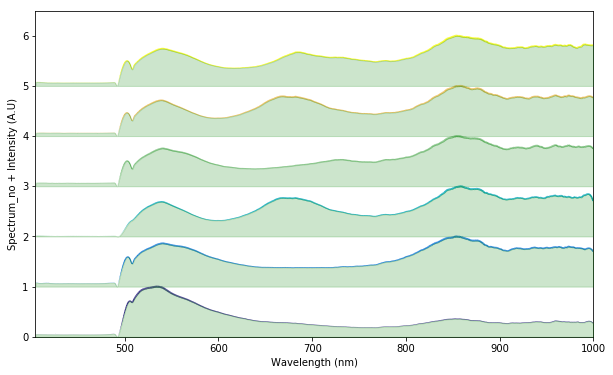

In [23]:
fig3 = plt.figure(3, figsize = (10,1*len(sorted_timestamps_offset_NP1)))
ax7 = fig3.add_subplot(111)
#ax10 = ax8.twiny()
#ax10.set_xlim(ax6.get_xlim())
#ax10.set_xticks(new_tick_locations)
#ax10.set_xticklabels(Alex_plot.energy_ticks(new_tick_locations))
#ax10.set_xlabel(r"Energy(eV)")


colours = parula_map(np.linspace(0,1,len(sorted_array_offset_NP1)))
for i in range(0, len(sorted_array_offset_NP1)):
    lwidths = (sorted_array_offset_NP1[i] - i)*2
    points = np.array([wavelength_store_NP1[0], sorted_array_offset_NP1[i]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    lc_2 = LineCollection(segments, linewidths = lwidths, color = colours[i])
    ax7.add_collection(lc_2)
    spec1 = np.array(sorted_array_offset_NP1[i], dtype = float)
    spec2 = np.array(len(sorted_array_offset_NP1[i])*[i], dtype = float)
    ax7.fill_between(wavelength_store_NP1[0], spec1, spec2, color = "green", 
                alpha = 0.2, zorder = 3)
    #ax7.scatter(sorted_peak_wls_NP1[i], np.full((1,7), sorted_pks_offset_NP1[i]))


ax7.set_ylim(0, len(sorted_timestamps_offset_NP1)+0.5)
ax7.set_xlim(405, 1000)
ax7.set_xlabel("Wavelength (nm)")
ax7.set_ylabel("Spectrum_no + Intensity (A.U)")